In [48]:
!pip uninstall  -y  socceraction

Found existing installation: socceraction 1.4.1
Uninstalling socceraction-1.4.1:
  Successfully uninstalled socceraction-1.4.1


In [49]:
!pip install socceraction[statsbomb]

  Using cached socceraction-1.4.1-py3-none-any.whl (86 kB)


In [50]:
!pip install tables==3.6.1
!pip install socceraction


  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects


In [51]:
!pip install fuzzywuzzy

In [52]:
import pandas as pd
from io import BytesIO
from datetime import timedelta
from datetime import datetime
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz
from six import StringIO
import pydotplus
from socceraction.spadl.wyscout import convert_to_spadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
from socceraction.data.statsbomb import StatsBombLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [7]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [8]:
# Function that returns decoded Json files better than panda
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [9]:
# Reading the Coaches Data
coaches_json = read_json_file('/content/drive/MyDrive/thesis/data/coaches.json')
coaches = pd.read_json(coaches_json)

# Checking for Nulls
coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

Birth day or age of a coach is not an important factor and even if it will be proved to be there is only two missing

In [10]:
# Visualizing the table to see how the data looks
coaches.head()

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0


In [11]:
# Reading the teams data
teams_json = read_json_file('/content/drive/MyDrive/thesis/data/teams.json')
teams = pd.read_json(teams_json)

# Checking for Nulls
teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [12]:
# Visualizing the table to see how the data looks
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [13]:
# Reading the players data
player_json = read_json_file('/content/drive/MyDrive/thesis/data/players.json')
players = pd.read_json(player_json)

# Checking for Nulls
players.isna().sum()

passportArea              0
weight                    0
firstName                 0
middleName                0
lastName                  0
currentTeamId            91
birthDate                 0
height                    0
role                      0
birthArea                 0
wyId                      0
foot                      0
shortName                 0
currentNationalTeamId     0
dtype: int64

With investigation it wa found these null values correspond to players that did not play that season and therefore have a ull team ID value and national team id as well

In [14]:
# Visualizing the table to see how the data looks
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [15]:
# Reading the Premier league matches data
matches_json = read_json_file('/content/drive/MyDrive/thesis/data/matches_England.json')
matches = pd.read_json(matches_json)

# Checking for Nulls
matches.isna().sum()

status           0
roundId          0
gameweek         0
teamsData        0
seasonId         0
dateutc          0
winner           0
venue            0
wyId             0
label            0
date             0
referees         0
duration         0
competitionId    0
dtype: int64

In [16]:
# Visualizing the table to see how the data looks
matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


In [17]:
# Reading the Premier league events data
PL_json = read_json_file('/content/drive/MyDrive/thesis/data/events_England.json')
PL = pd.read_json(PL_json)

# Checking for Nulls
PL.isna().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

In [18]:
# Visualizing the table to see how the data looks
PL.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


# Question 1: How do different measures of similarity between event sequences relate to a football team’s performance? And which of them is most important in predicting success?

## Sequence Analysis

In [ ]:
# Adding a row that will help in determining the end of a sequence
PL['sequence_analysis'] = PL['teamId'].shift(1)
print(PL[PL.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
PL = PL.drop(PL[PL.eventName=='Foul'].index)

['Foul' 'Hand foul' 'Violent Foul' 'Protest' 'Late card foul'
 'Out of game foul' 'Time lost foul' 'Simulation']


In [ ]:
seq = 0
top_5 = ['Manchester City','Chelsea','Manchester United','Tottenham Hotspur','Liverpool']
top_middle = ['Arsenal', 'Leicester City','Burnley','Newcastle United','Everton']
bottom_middle = ['Crystal Palace','AFC Bournemouth','Watford','Brighton & Hove Albion','West Ham United']
# Creating a Column stating whether the team is playing home or away
def team_side(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  side = teams_data[str(row.teamId)]['side']
  return side

# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name']
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  position = row.positions[1]['y']
  return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  position = row.positions[1]['x']
  return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Creating a Column of Match Rank
def type_of_match(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  teams_in_match = list(teams_data.keys())
  teams_in_match.remove(str(row.teamId))
  against = int(teams_in_match[0])
  teams_in_play = [row.teamId, against]
  team_rank = []
  for i in teams_in_play:
    name = teams[teams['wyId']==i].iloc[0]['name']
    if name in top_5:
      team_rank.append('Top 5')
    elif name in top_middle:
      team_rank.append('Top Middle 5')
    elif name in bottom_middle:
      team_rank.append('Bottom Middle 5')
    else:
      team_rank.append('Bottom 5')

  match_rank = ' vs '.join(team_rank)
  return match_rank

# Calculating the Columns
PL['Side'] = PL.apply(team_side,axis=1)
PL['Name'] = PL.apply(team_name,axis=1)
PL['start_y'] = PL.apply(start_y,axis=1)
PL['end_y'] = PL.apply(end_y,axis=1)
PL['start_x'] = PL.apply(start_x,axis=1)
PL['end_x'] = PL.apply(end_x,axis=1)
PL['Timestamp'] = PL.apply(timestamp,axis=1)
PL['Sequence'] = PL.apply(sequence_groups,axis=1)
PL['Match Rank'] = PL.apply(type_of_match,axis=1)

In [ ]:
# Removing all Sequences that are shorter than 3 Events
PL = PL[PL.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = PL.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Pass
['Simple pass' 'High pass' 'Cross' 'Head pass' 'Smart pass' 'Launch'
 'Hand pass']
Duel
['Ground attacking duel' 'Air duel' 'Ground loose ball duel'
 'Ground defending duel']
Shot
['Shot']
Interruption
['Ball out of the field' 'Whistle']
Offside
['']
Others on the ball
['Touch' 'Clearance' 'Acceleration']
Free Kick
['Throw in' 'Goal kick' 'Corner' 'Free Kick']
Goalkeeper leaving line
['Goalkeeper leaving line']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
count = 0
for index , row in end_event.iterrows():
  count+=1
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
PL['Successful'] = PL.apply(sucessful_seq,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
PL_analyis = PL[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Side','Match Rank','Successful']]

In [ ]:
#Visualizing the resulting Dataframe
PL_analyis.head()

,Sequence,eventName,subEventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful
0,1,Pass,Simple pass,25413,2499719,2017-08-11T18:45:02.758649,1H,49,78,49,31,Arsenal,home,Top Middle 5 vs Top Middle 5,1
1,1,Pass,High pass,370224,2499719,2017-08-11T18:45:04.946850,1H,78,75,31,51,Arsenal,home,Top Middle 5 vs Top Middle 5,1
2,1,Pass,Head pass,3319,2499719,2017-08-11T18:45:06.542188,1H,75,71,51,35,Arsenal,home,Top Middle 5 vs Top Middle 5,1
3,1,Pass,Head pass,120339,2499719,2017-08-11T18:45:08.143395,1H,71,95,35,41,Arsenal,home,Top Middle 5 vs Top Middle 5,1
4,1,Pass,Simple pass,167145,2499719,2017-08-11T18:45:10.302366,1H,95,88,41,72,Arsenal,home,Top Middle 5 vs Top Middle 5,1


In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
PL_analyis = PL_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
PL_analyis = PL_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-22-7d5f1d705ad3>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-22-7d5f1d705ad3>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-22-7d5f1d705ad3>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-22-7d5f1d705ad3>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-22-7d5f1d705ad3>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
PL_analyis.head(20)

,Sequence,eventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful
0,1,In,25413,2499719,2017-08-11T18:45:02.758649,1H,49,78,49,31,Arsenal,home,Top Middle 5 vs Top Middle 5,1
1,1,Pass,25413,2499719,2017-08-11T18:45:02.758649,1H,49,78,49,31,Arsenal,home,Top Middle 5 vs Top Middle 5,1
2,1,Pass,370224,2499719,2017-08-11T18:45:04.946850,1H,78,75,31,51,Arsenal,home,Top Middle 5 vs Top Middle 5,1
3,1,Pass,3319,2499719,2017-08-11T18:45:06.542188,1H,75,71,51,35,Arsenal,home,Top Middle 5 vs Top Middle 5,1
4,1,Pass,120339,2499719,2017-08-11T18:45:08.143395,1H,71,95,35,41,Arsenal,home,Top Middle 5 vs Top Middle 5,1
5,1,Pass,167145,2499719,2017-08-11T18:45:10.302366,1H,95,88,41,72,Arsenal,home,Top Middle 5 vs Top Middle 5,1
6,1,Pass,3319,2499719,2017-08-11T18:45:12.548934,1H,88,75,72,77,Arsenal,home,Top Middle 5 vs Top Middle 5,1
7,1,Out,3319,2499719,2017-08-11T18:45:12.548934,1H,88,75,72,77,Arsenal,home,Top Middle 5 vs Top Middle 5,1
8,3,In,0,2499719,2017-08-11T18:45:14.765321,1H,85,80,61,67,Arsenal,home,Top Middle 5 vs Top Middle 5,0
9,3,Duel,0,2499719,2017-08-11T18:45:14.765321,1H,85,80,61,67,Arsenal,home,Top Middle 5 vs Top Middle 5,0


In [ ]:
os.mkdir('/content/drive/MyDrive/thesis/Premier League/Match Rank')
match_rank = PL_analyis['Match Rank'].unique()
success = PL_analyis['Successful'].unique()
for i in match_rank:
  df  = PL_analyis[PL_analyis['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/Premier League/Match Rank/'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/Premier League/Match Rank/'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
teams = PL_analyis.Name.unique()
success = PL_analyis.Successful.unique()
sides = PL_analyis.Side.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/Premier League/'+ team
  team_events = PL_analyis[PL_analyis['Name']== team]
  os.mkdir(path)
  for side in sides:
    sub_path = path +'/' + team +' ' + side
    side_team_events =  team_events[team_events['Side']==side]
    for num in success:
      sub_df = side_team_events[side_team_events['Successful']==num]
      if num==1:
        final_path = sub_path +' Success.csv'
      else:
        final_path = sub_path +' Unsuccess.csv'
      sub_df.to_csv(final_path,index=False)

## Success Reason Analysis

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName']=='Pass']
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName']=='Pass']
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(PL_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(PL_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(PL_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(PL_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Home or Away
side = list(PL_analyis.groupby(['Sequence'])['Side'].first())
perform['Side'] = side

# Overall time of the Sequence
time = list(PL_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(PL_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(PL_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(PL_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(PL_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(PL_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(PL_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(PL_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Side,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,1,Pass,1H,Arsenal,home,9.790285,45.276926,28,2.859978,23.549298,...,0,1,0,0,1,1,0,0,0,1
1,3,Duel,1H,Arsenal,home,5.661206,43.081318,10,1.766408,19.299926,...,0,1,0,0,1,0,0,0,0,0
2,6,Pass,1H,Leicester City,away,6.901369,26.019224,39,5.651053,23.501470,...,1,0,0,0,0,0,0,0,0,0
3,18,Free Kick,1H,Arsenal,home,8.938005,39.824616,31,3.468335,16.629535,...,0,0,0,0,0,0,1,0,0,1
4,22,Pass,1H,Arsenal,home,7.822331,38.052595,10,1.278391,49.078899,...,0,0,0,1,1,0,0,1,1,1


In [ ]:
# Analyzing the team style of play
team_style = perform[['Name','Speed','Num of Passes']]
team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
team_style.dropna(inplace = True)
team_style_grouped = team_style.groupby(['Name']).mean()
team_style_grouped.head(20)
rank = []
for index, row in team_style_grouped.iterrows():
  if index in top_5:
    rank.append('Top 5')
  elif index in top_middle:
    rank.append('Top Middle 5')
  elif index in bottom_middle:
    rank.append('Bottom Middle 5')
  else:
    rank.append('Bottom 5')
team_style_grouped['Rank'] = rank
team_style_grouped.head(20)

<ipython-input-22-76ef5b463e9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-22-76ef5b463e9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.dropna(inplace = True)


,Speed,Num of Passes,Rank
Name,,,
AFC Bournemouth,2.921450,3.508628,Bottom Middle 5
Arsenal,2.686217,5.198413,Top Middle 5
Brighton & Hove Albion,3.152868,3.478973,Bottom Middle 5
Burnley,3.246830,3.172266,Top Middle 5
Chelsea,2.558287,4.541456,Top 5
Crystal Palace,3.145085,3.222633,Bottom Middle 5
Everton,2.876811,3.358600,Top Middle 5
Huddersfield Town,3.044863,3.392491,Bottom 5
Leicester City,3.059650,3.408981,Top Middle 5


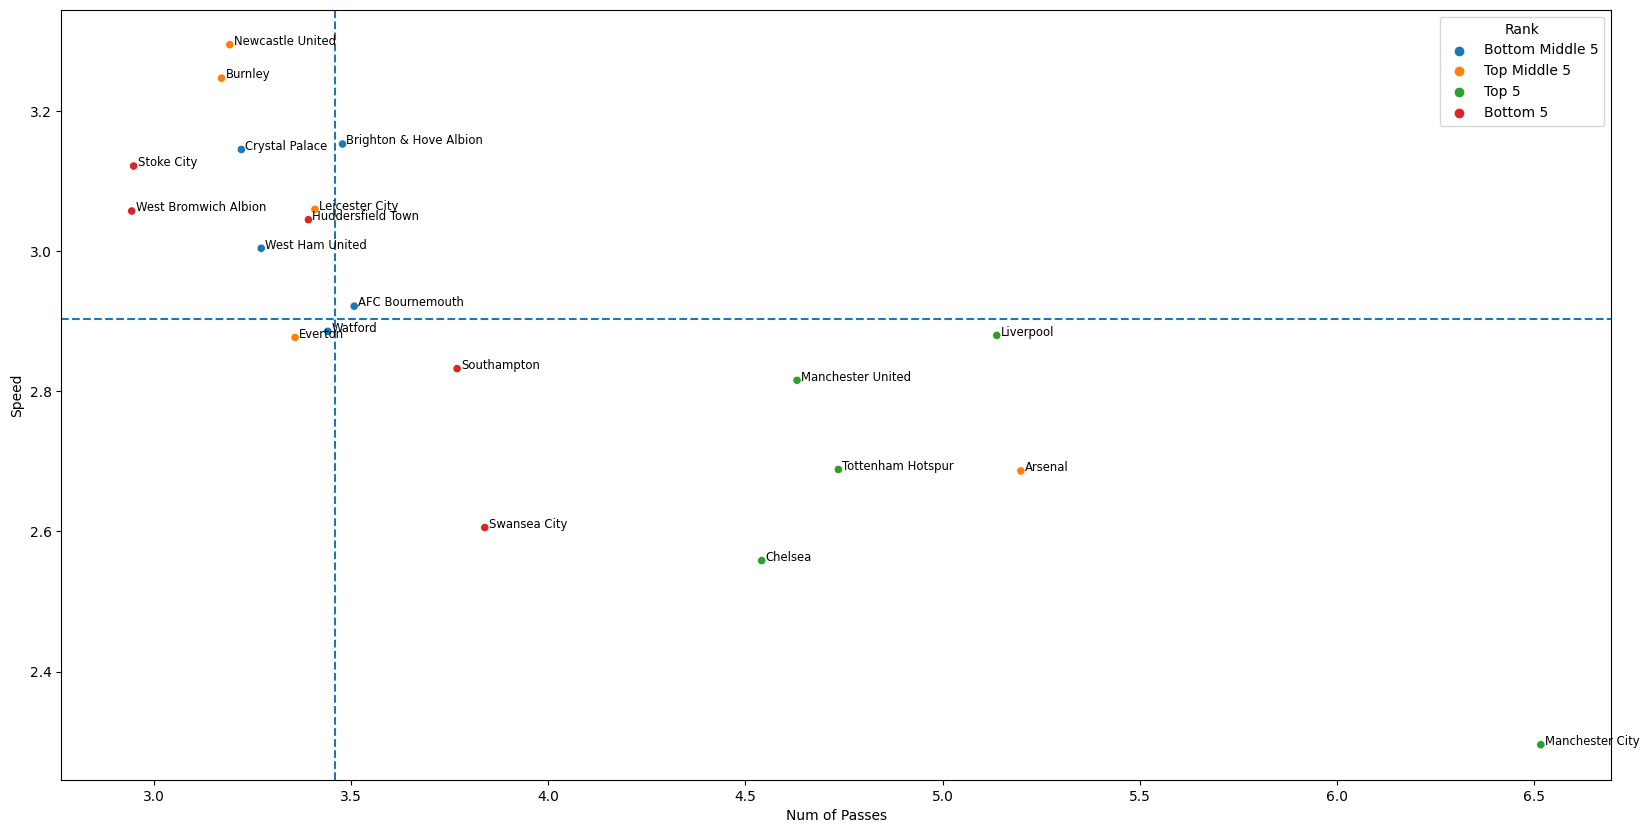

In [ ]:
# Visualizing that style
speed_med = team_style_grouped['Speed'].median()
pass_med = team_style_grouped['Num of Passes'].median()
ax = plt.figure(figsize=(20,10))
plt1 = sns.scatterplot(data = team_style_grouped, x='Num of Passes', y='Speed',hue = 'Rank')
plt1.axvline(x = pass_med, ymin = 0, ymax = 1,linestyle = "dashed")
plt1.axhline(y = speed_med, xmin = 0, xmax = 1,linestyle = "dashed")
for line in range(0,team_style_grouped.shape[0]):
     plt1.text(team_style_grouped['Num of Passes'][line]+0.01, team_style_grouped.Speed[line],
     team_style_grouped.index[line], horizontalalignment='left',
     size='small')

In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period','Side']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Others on the ball' 'Pass' 'Save attempt' 'Shot']
['1H' '2H']
['away' 'home']


In [ ]:
# Dividing the data in train and test subsets
y = perform_encoded.Successful
X = perform_encoded.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.7987187886729271

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=5)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.00011945153843782353}
0.8303304479100657


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8327145664992356

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/Premier League/Premier_League_DT.png')

True

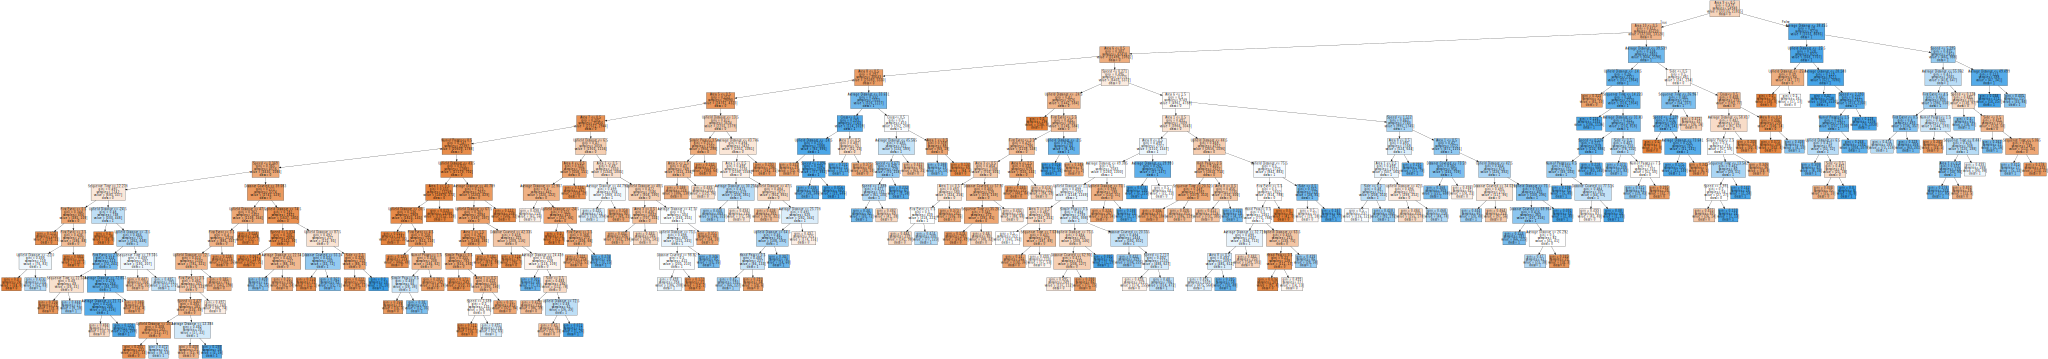

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

# Question 2:	How can event sequence analysis identify the key players and positions that contribute most to a team's success in football, and what insights can be gained from this analysis?

In [19]:
# Transforming the teams data to H5 format
teams.to_hdf('PL.h5', key='teams', mode='w')

# Transforming the players data to H5 format
players.to_hdf('PL.h5', key='players', mode='a')

# Transforming the matches data to H5 format
matches.to_hdf('PL.h5', key='matches', mode='a')

# Transforming the event data to H5 format grouped per
events_grouped_per_match = PL.groupby('matchId', as_index=False)
for id, events_per_match in events_grouped_per_match:
  events_per_match.to_hdf('PL.h5', key=f'events/match_{id}', mode='a')

# Converting the above data to SPAL format
convert_to_spadl('PL.h5', 'spadl.h5')

<ipython-input-19-1e35d0fc6e6b>:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['city', 'name', 'officialName', 'area', 'type'], dtype='object')]

  teams.to_hdf('PL.h5', key='teams', mode='w')
<ipython-input-19-1e35d0fc6e6b>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['passportArea', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'role', 'birthArea', 'foot', 'shortName',
       'currentNationalTeamId'],
      dtype='object')]

  players.to_hdf('PL.h5', key='players', mode='a')
<ipython-input-19-1e35d0fc6e6b>:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] 

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 380/380 [00:37<00:00, 10.13game/s]


...Converting events to actions


100%|██████████| 380/380 [04:45<00:00,  1.33game/s]


In [20]:
# Reading the required datasets from the SPAL format
games = pd.read_hdf('spadl.h5', key='games')
action_types = pd.read_hdf('spadl.h5', key='actiontypes')
body_parts = pd.read_hdf('spadl.h5', key='bodyparts')
results = pd.read_hdf('spadl.h5', key='results')

In [21]:
# Grouping all the necessary feature generators
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

# Retrieving the column names generated by the features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)

# Grouping the target feature generators
functions_labels = [labels.scores,labels.concedes]
target_features = ['scores','concedes']

In [22]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Transforming the events to Game States
    gamestates = features.gamestates(actions, nb_prev_actions=3)
    gamestates = features.play_left_to_right(gamestates, game['home_team_id'])

# Extracting the features stated above and transforming it to H5 format
    features_df = pd.concat([function(gamestates) for function in functions_features], axis=1)
    features_df.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [23]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Extracting the labels stated above and transforming it to H5 format
    labels_df = pd.concat([function(actions) for function in functions_labels], axis=1)
    labels_df.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [24]:
# Retreiving the relevant features and transforming them into a panda dataframe
features_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    features_per_game = pd.read_hdf('features.h5', key=f'game_{game_id}')
    features_list.append(features_per_game[columns_features])
features_df = pd.concat(features_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [25]:
# Visualizing the table to see how the features looks
features_df.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,63.091679,0.053916,63.091679,0.053916,63.091679,0.053916,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,68.328929,0.355773,63.091679,0.053916,63.091679,0.053916,True,True,1.997756,1.997756
2,True,False,False,False,False,False,False,False,False,False,...,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,True,True,0.771744,2.769500
3,True,False,False,False,False,False,False,False,False,False,...,38.707772,0.396818,73.715416,0.185556,68.328929,0.355773,True,True,2.174464,2.946208
4,True,False,False,False,False,False,False,False,False,False,...,37.425928,0.620467,38.707772,0.396818,73.715416,0.185556,True,True,3.907382,6.081846


In [26]:
# Retreiving the relevant labels and transforming them into a panda dataframe
labels_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    labels_per_game = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    labels_list.append(labels_per_game[target_features])
labels_df = pd.concat(labels_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [27]:
# Visualizing the table to see how the features looks
labels_df.head()

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [30]:
print(len(labels_df))
print(len(labels_df))

483665
483665


In [29]:
# Training a classifier model for each label
models = {}
for label in target_features:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(features_df, labels_df[label])
    models[label] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [31]:
# Using the trained models to transform the labels dataframe from true/false to probability of being true
probabilities_dict = {}
for label in target_features:
    model = models[label]
    probabilities = model.predict_proba(features_df)
    predictions = probabilities[:, 1]
    probabilities_dict[label] = pd.Series(predictions)
probabilities_df = pd.concat(probabilities_dict, axis=1)

In [32]:
# Extracting the game ids to have them with probabilties df and merging both into one
games_ids_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    games_ids_list.append(actions['game_id'])
game_ids_df = pd.concat(games_ids_list, axis=0).astype('int').reset_index(drop=True)
probabilities_df = pd.concat([probabilities_df, game_ids_df], axis=1)

  0%|          | 0/380 [00:00<?, ?it/s]

In [33]:
# Visualizing the table to see how the probabilities looks
probabilities_df.head()

,scores,concedes,game_id
0,0.001565,0.000516,2500089
1,0.002807,0.001275,2500089
2,0.002975,0.000562,2500089
3,0.009620,0.002700,2500089
4,0.017388,0.001116,2500089


In [34]:
# Grouping the probabilities by match
probabilities_per_game = probabilities_df.groupby('game_id')

# Saving them in H5 format
for game_id, probabilities in tqdm(probabilities_per_game):
    probabilities = probabilities.reset_index(drop=True)
    probabilities[target_features].to_hdf('probabilities.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [35]:
# VAEP Calculations
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []

for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .merge(players, how='left')
        .merge(teams, how='left')
        .reset_index(drop=True)
    )
    probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
    values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
    all_df = pd.concat([actions, probabilities_df, values], axis=1)
    all_per_game.append(all_df)

# transforming all to pandas dataframe
vaep_rating = pd.concat(all_per_game)

  0%|          | 0/380 [00:00<?, ?it/s]

In [36]:
# Extracting minutes played by player
player_games = pd.read_hdf('spadl.h5', 'player_games')
player_games = player_games[player_games['game_id'].isin(games['game_id'])]
minutes_played = (player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [37]:
# Aggregating the results and grouping them by player
players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

# Adding column minutes played total per player
players_ratings = players_ratings.merge(minutes_played)

# Removing any player plaing less than 450 minutes (5 matches all league)
players_ratings = players_ratings[players_ratings['minutes_played'] > 450]

# Transforming VAEP to show players rating per match
players_ratings['vaep_per_match'] = players_ratings['vaep_sum'] * 90 / players_ratings['minutes_played']

# Average actions per plaer per match
players_ratings['actions_per_match'] = players_ratings['vaep_count'] * 90 / players_ratings['minutes_played']

# Sorting value by VAEP per match
players_ratings = players_ratings.sort_values('vaep_per_match', ascending=False)

In [38]:
# Adding two more columns that describes VAEP rating into success and fail actions
risk = pd.pivot_table(vaep_rating, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
risk = risk.reset_index()
risk = risk[0:-1]
risk = risk[['player_id','success','fail']]

# Merging these two columns with the players ratings
players_ratings = pd.merge(players_ratings, risk, on=['player_id'])

# Normalizing them to 90 minutes
players_ratings['success'] = players_ratings['success'] / players_ratings['minutes_played'] * 90
players_ratings['fail'] = players_ratings['fail'] / players_ratings['minutes_played'] * 90

In [39]:
# Visualizing the players ratings
players_ratings.head()

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
0,3802.0,Liverpool FC,Philippe Coutinho,1014,9.415454,0.009285,1134.538547,0.746904,80.437990,1.091177,-0.330123
1,120353.0,Liverpool FC,Mohamed Salah,1568,23.892843,0.015238,2996.529579,0.717615,47.094479,1.049092,-0.327899
2,25707.0,Chelsea FC,E. Hazard,1974,16.345870,0.008281,2505.438518,0.587174,70.909742,0.830239,-0.239388
3,38021.0,Manchester City FC,K. De Bruyne,3528,19.345658,0.005483,3190.369684,0.545739,99.524516,0.854150,-0.305327
4,26150.0,Leicester City FC,R. Mahrez,2022,18.507026,0.009153,3063.065477,0.543780,59.411071,0.707344,-0.163294


In [53]:
# Getting the top 4 leagues positions data
api=StatsBombLoader(getter="remote",creds=None)
english = api.games(competition_id=2,season_id=27)
italy = api.games(competition_id=12,season_id=27)
spain = api.games(competition_id=11,season_id=27)
german = api.games(competition_id=9,season_id=27)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [56]:
list_of_players = []
# Extracting the position of players in Premier League
unique_games = english['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass


# Extracting the position of players in Serie A
unique_games = italy['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in La Liga
unique_games = spain['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in Bundesliga
unique_games = german['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/pyth

In [70]:
# Putting all together
players_position = pd.concat(list_of_players)
players_position.head()

,player_id,player_name,starting_position_name
0,3049,Matt Ritchie,Right Midfield
1,3085,Glenn Murray,Substitute
2,3304,Harry Arter,Left Center Midfield
3,3341,Steve Cook,Left Center Back
4,3343,Dan Gosling,Right Center Midfield


In [71]:
# Determining the position the most played by each player
names = []
position = []
for name in players_position.player_name.unique():
  position_per_player = players_position[players_position['player_name']==name]
  names.append(name)
  if position_per_player.starting_position_name.value_counts().index[0] == 'Substitute':
    try:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[1])
    except:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
  else:
    position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
players_position = pd.DataFrame(list(zip(names, position)),columns =['player_name', 'position'])

In [74]:
# Function that matches names from 2 Dataframes
def fuzzy_merge(df_1, df_2, key1, key2, threshold=0, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit,scorer=fuzz.token_set_ratio))
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    return df_1

In [75]:
# Applying the function
players_ratings = fuzzy_merge(players_ratings, players_position, 'short_name', 'player_name')

In [76]:
players_ratings

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail,matches
0,3802.0,Liverpool FC,Philippe Coutinho,1014,9.415454,0.009285,1134.538547,0.746904,80.437990,1.091177,-0.330123,Philippe Coutinho Correia
1,120353.0,Liverpool FC,Mohamed Salah,1568,23.892843,0.015238,2996.529579,0.717615,47.094479,1.049092,-0.327899,Mohamed Salah
2,25707.0,Chelsea FC,E. Hazard,1974,16.345870,0.008281,2505.438518,0.587174,70.909742,0.830239,-0.239388,Eden Hazard
3,38021.0,Manchester City FC,K. De Bruyne,3528,19.345658,0.005483,3190.369684,0.545739,99.524516,0.854150,-0.305327,Kevin De Bruyne
4,26150.0,Leicester City FC,R. Mahrez,2022,18.507026,0.009153,3063.065477,0.543780,59.411071,0.707344,-0.163294,Riyad Mahrez
...,...,...,...,...,...,...,...,...,...,...,...,...
420,21095.0,Manchester United FC,M. Darmian,316,-0.313591,-0.000992,467.587408,-0.060359,60.822853,-0.018871,-0.042271,Matteo Darmian
421,134351.0,AFC Bournemouth,B. Afobe,207,-0.496194,-0.002397,663.852756,-0.067270,28.063452,0.062183,-0.129453,Benik Afobe
422,265318.0,West Ham United FC,E. Fernandes,373,-0.701361,-0.001880,881.226833,-0.071630,38.094618,0.032042,-0.103731,Bruno Miguel Borges Fernandes
423,9532.0,Stoke City FC,S. Berahino,143,-0.659986,-0.004615,539.702359,-0.110058,23.846477,-0.010005,-0.100054,Saido Berahino


In [77]:
players_ratings.matches.value_counts()

Carlos Alberto Sánchez Moreno    6
Jordan Ayew                      5
Joshua King                      5
Theo Walcott                     4
Alex Oxlade-Chamberlain          4
                                ..
Thomas Robson                    1
Jan Vertonghen                   1
Jonjoe Kenny                     1
Jordan Brian Henderson           1
Bruno Miguel Borges Fernandes    1
Name: matches, Length: 348, dtype: int64

In [78]:
# Creating a new column for each player and his position
positions = []
for id,row in players_ratings.iterrows():
  player = row['matches']
  info = players_position[players_position['player_name']==player]
  position = info['position'].iloc[0]
  positions.append(position)
players_ratings['position'] = positions

In [82]:
# Understanding the number of players in each position
players_ratings.groupby(['position'])['position'].count()


position
CAM    25
CB     72
CDM    48
CF     49
GK     32
LB     32
LCM    14
LM      8
LW     31
RB     39
RCM    17
RM      7
RW     30
Sub    21
Name: position, dtype: int64

In [80]:
# Putting all CBs, RCBs and LCBs as CBs
players_ratings.replace('Left Center Back','Center Back', inplace = True)
players_ratings.replace('Right Center Back','Center Back', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Center Forward','Center Forward', inplace = True)
players_ratings.replace('Right Center Forward','Center Forward', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Defensive Midfield','Center Defensive Midfield', inplace = True)
players_ratings.replace('Right Defensive Midfield','Center Defensive Midfield', inplace = True)

# Putting all RWBs to RBs and LWBs to LBs
players_ratings.replace('Left Wing Back','Left Back', inplace = True)
players_ratings.replace('Right Wing Back','Right Back', inplace = True)

In [81]:
# Abbreviating all positions
players_ratings.replace('Left Center Midfield','LCM', inplace = True)
players_ratings.replace('Center Attacking Midfield','CAM', inplace = True)
players_ratings.replace('Left Wing','LW', inplace = True)
players_ratings.replace('Right Midfield','RM', inplace = True)
players_ratings.replace('Right Wing','RW', inplace = True)
players_ratings.replace('Right Center Midfield','RCM', inplace = True)
players_ratings.replace('Substitute','Sub', inplace = True)
players_ratings.replace('Left Back','LB', inplace = True)
players_ratings.replace('Center Defensive Midfield','CDM', inplace = True)
players_ratings.replace('Left Midfield','LM', inplace = True)
players_ratings.replace('Center Forward','CF', inplace = True)
players_ratings.replace('Right Back','RB', inplace = True)
players_ratings.replace('Center Back','CB', inplace = True)
players_ratings.replace('Goalkeeper','GK', inplace = True)

In [83]:
# Aggregating and grouping by player position
positions_ranks = players_ratings.groupby(['position']).mean()

<ipython-input-83-ea2832b3073a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks = players_ratings.groupby(['position']).mean()


In [84]:
# Seeing the table
positions_ranks

,player_id,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
position,,,,,,,,,
CAM,67595.720000,1293.720000,4.788614,0.003455,1984.585452,0.212684,61.477784,0.325488,-0.111702
CB,74985.333333,1154.152778,2.725945,0.002265,1845.214741,0.128568,55.645183,0.186128,-0.057188
CDM,55547.479167,1403.770833,3.862461,0.002770,2025.419825,0.162750,61.419731,0.248545,-0.085219
CF,33223.612245,648.571429,2.986344,0.004588,1646.525357,0.146284,32.325389,0.309461,-0.162422
GK,74072.062500,919.718750,2.248073,0.002423,2183.146241,0.096266,39.723736,0.136350,-0.039629
LB,54265.718750,1413.875000,3.781223,0.002729,2046.399982,0.162541,61.247033,0.250497,-0.086419
LCM,67031.285714,1371.000000,4.345874,0.002957,1985.795541,0.193044,61.481708,0.283876,-0.088793
LM,44860.250000,974.500000,2.325184,0.002294,1676.068811,0.119415,51.142951,0.223643,-0.103630
LW,42240.903226,921.322581,4.298088,0.003748,1842.653265,0.207674,43.030789,0.348439,-0.139602


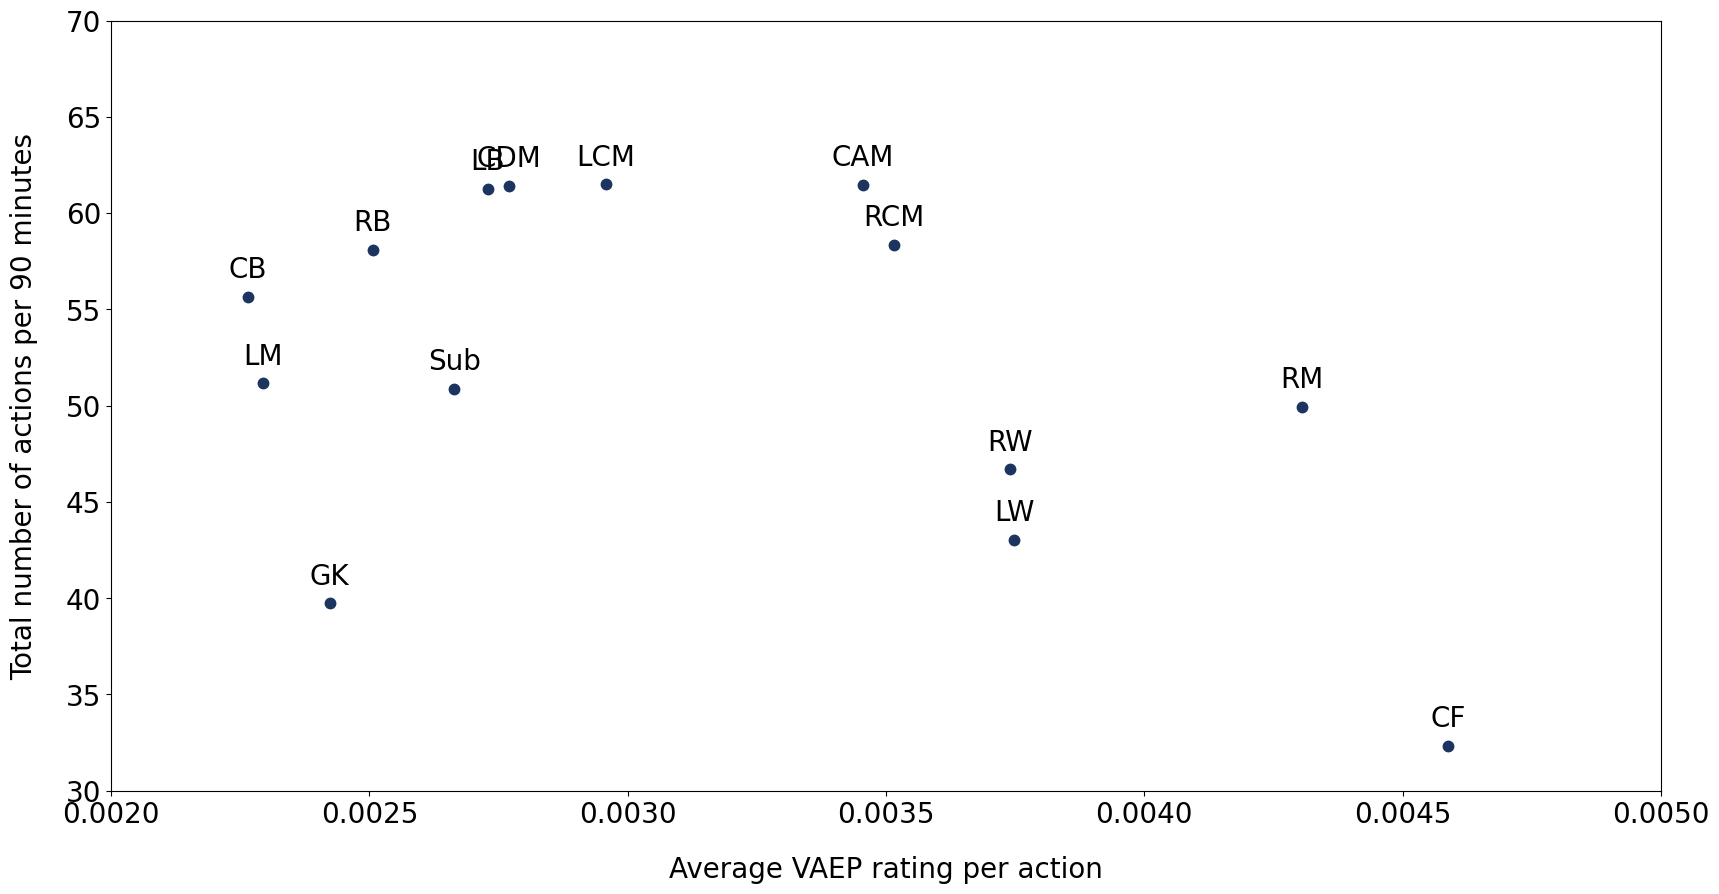

In [86]:
# Analyzing Quantity vs Quality
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['vaep_mean'])
y = list(positions_ranks['actions_per_match'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 1), fontsize=20, horizontalalignment='center')



plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.002, 0.005)
plt.ylim(30, 70)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total number of actions per 90 minutes', labelpad=20, fontsize=20)
plt.show()

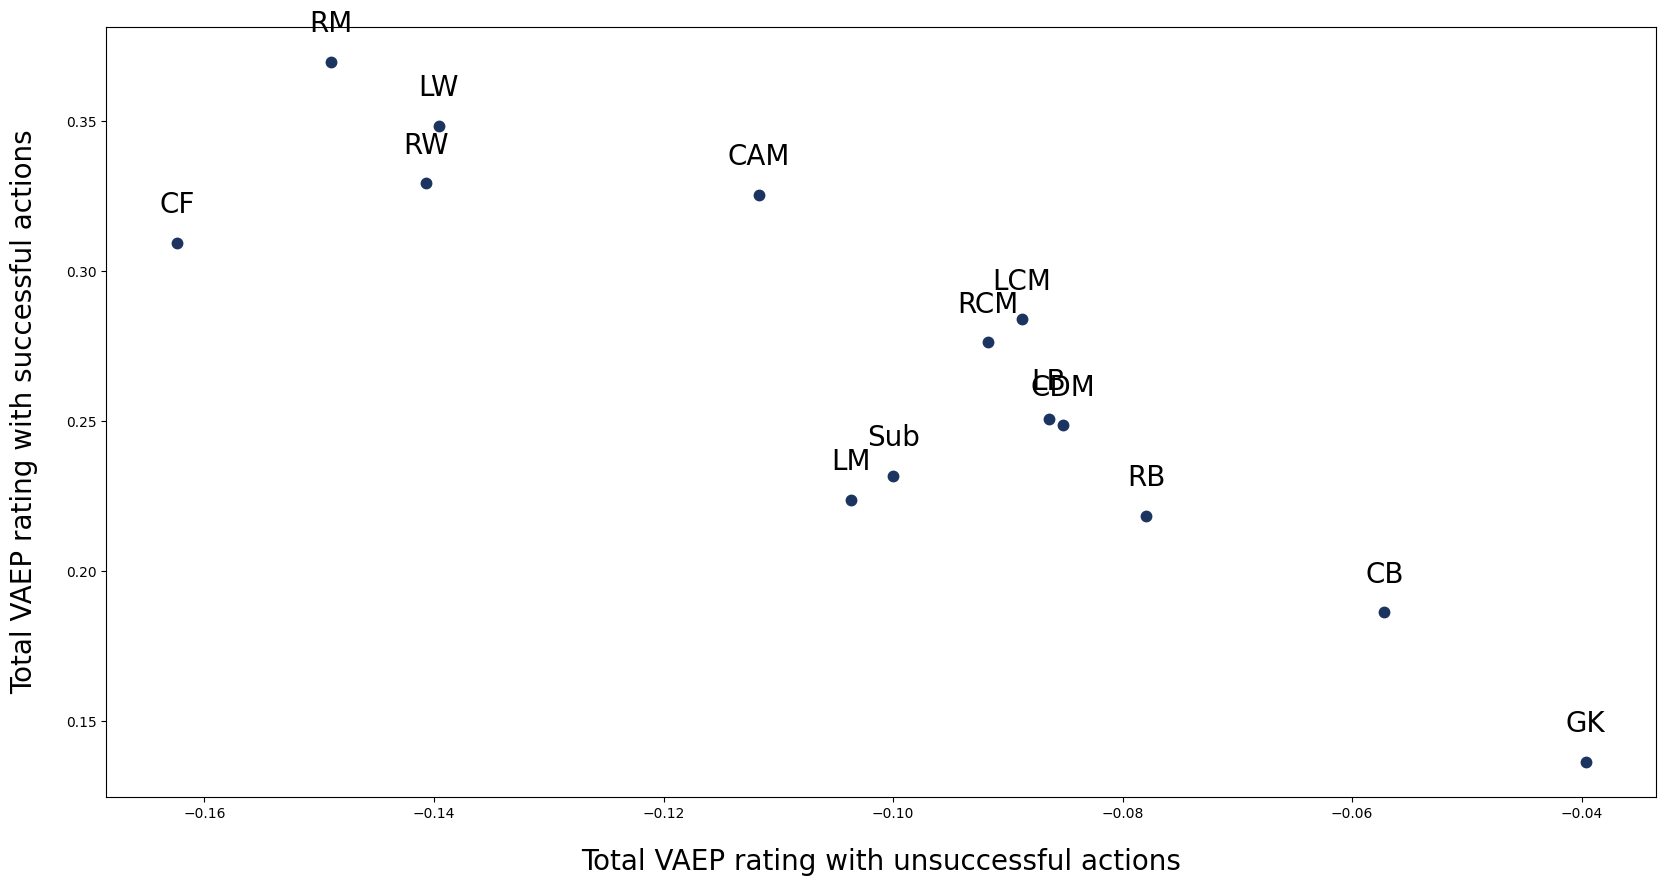

In [87]:
# Analyzing Risk taken by position
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['fail'])
y = list(positions_ranks['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]+ 0.01), fontsize=20, horizontalalignment='center')

plt.xlabel('Total VAEP rating with unsuccessful actions', labelpad=20, fontsize=20)
plt.ylabel('Total VAEP rating with successful actions', labelpad=20, fontsize=20)
plt.show()

In [88]:
# Getting Best 3 position by Club
positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])
positions_ranks_by_club.groupby(level=0).head(3)

<ipython-input-88-290b12a981b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])


player_id   vaep_count   vaep_sum  \
team_name                 position                                          
AFC Bournemouth           LCM         9283.000000   724.000000   2.860441   
                          CDM         8351.000000  1432.000000   4.810945   
                          GK         35475.000000  1287.500000   5.416157   
Arsenal FC                CAM         3319.000000  2278.000000  11.466359   
                          LB          9214.500000  1934.500000   7.053955   
                          CDM        36961.400000  1750.600000   6.439064   
Brighton & Hove Albion FC RCM        20738.000000  1662.000000   7.621118   
                          CB         56118.000000   853.000000   3.052507   
                          Sub         8086.000000  2219.000000   4.146893   
Burnley FC                RCM         8752.000000  1108.666667   4.704255   
                          CDM         9123.000000   792.000000   5.050219   
                          RB          5680.666667  1306.333333   5.064454   
Chelsea FC                CDM        17439.000000  2609.000000  10.071834   
                          LCM         8495.000000   461.000000   2.043235   
                          RW         56979.000000  1426.000000   7.122112   
Crystal Palace FC         LW         25865.000000   235.000000   2.603653   
                          RM          8422.000000  1339.000000   7.817789   
                          LB          4477.500000  1324.500000   6.103670   
Everton FC                LW          8317.333333   494.000000   4.099565   
                          CF         62090.666667   796.000000   4.159637   
                          CAM       215397.000000  1109.500000   5.740172   
Huddersfield Town FC      Sub        21412.000000  1356.000000   3.943958   
                          RCM        38377.000000   592.000000   3.356103   
                          CB        115592.400000  1132.000000   3.290653   
Leicester City FC         RM        151576.000000  1180.500000   9.744635   
                          LW        283142.000000   954.000000   6.249534   
                          CAM         3928.000000  1071.000000   3.809684   
Liverpool FC              LW          3802.000000  1014.000000   9.415454   
                          RW         45363.000000  1242.666667  12.435046   
                          CAM        13890.333333  1528.000000   7.815509   
Manchester City FC        RW         38021.000000  3528.000000  19.345658   
                          CF          8325.000000   982.000000   9.357156   
                          CAM       124940.500000  1852.000000   7.592659   
Manchester United FC      LW        134513.000000  1108.000000   8.288832   
                          LCM         7936.000000  2208.000000  11.244639   
                          CF        202541.500000  1011.000000   7.578950   
Newcastle United FC       LCM         7967.000000  1794.000000   7.102889   
                          CDM       171656.000000  1250.000000   3.572455   
                          CB         18187.666667   964.666667   3.890520   
Southampton FC            Sub         8136.000000  1276.000000   5.343333   
                          CAM        61988.000000  1296.000000   3.382879   
                          LW           383.000000  1715.000000   5.796811   
Stoke City FC             RW         28914.500000  1014.500000   6.493266   
                          LCM        77548.000000  1871.000000   6.034735   
                          RCM        33455.000000  1037.500000   2.865615   
Swansea City AFC          LCM        61962.000000  1123.000000   5.454276   
                          RB         85127.000000  1695.666667   2.905794   
                          CF          6929.750000   555.000000   2.136108   
Tottenham Hotspur FC      LW            54.000000  2959.000000  16.916641   
                          CF          8717.000000  1153.000000  14.539509   
                          RB        